<a href="https://colab.research.google.com/github/umeshnmenon/EVA4/blob/master/EVA4_S5_Assmnt_Notebook1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Target:
   ## 1. Get the basic structure right - All cells must run corretly for a DNN task.
   ## 2. Add ReLU and BatchNorm in every convolution layer except at last before output layer
   ## 3. Make the model lighter - With less than 10k parameter
   ## 4. Add maxpooling at RF = 5 (by looking at the image)
   ## 5. Add Gobal average pooling

# Result:
   ## 1. Parameters: 7,600
   ## 2. Best train accuracy: 99.13
   ## 3. Best test accuracy: 99.07(13th epoch)

# Analysis:
    ## 1. The model is good and light
    ## 2. At 19th epoch train accuracy: 99.33 and test accuracy: 99.04 (we see overfitting)
    ## 3. Need to use Regularization

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # INPUT BLOCK
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),           
            nn.ReLU(),                              
            nn.BatchNorm2d(16))  # output_size = 26, RF = 3                   
        
        # CONVOLUTION BLOCK 1
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),          
            nn.ReLU(),                              
            nn.BatchNorm2d(32)) # output_size = 24, RF = 5
                                 
        
        # TRANSITION BLOCK 1
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=8, kernel_size=(1, 1), padding=0, bias=False)
        ) # output_size = 24, RF = 5          
        self.maxpool = nn.MaxPool2d(2,2) # output_size = 12, RF = 6                               

        # CONVOLUTION BLOCK 2
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),           
            nn.ReLU(),                             
            nn.BatchNorm2d(8)) # output_size = 10, RF = 10

        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),          
            nn.ReLU(),                            
            nn.BatchNorm2d(8)) # output_size = 8, RF = 14                    
                    
        
        self.conv6=nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=1, bias=False),  
            nn.ReLU(),                              
            nn.BatchNorm2d(8))  # output_size = 8, RF = 18                      
                                
        
        self.conv7=nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=10, kernel_size=(3, 3), padding=0, bias=False)
        )  # output_size = 6, RF = 22           
                                                                         
                                                                           
                                  
        # OUTPUT BLOCK   
        self.GAP=nn.AvgPool2d(6)  # output_size = 1, RF = 32
                                                                      
       
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.maxpool(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.GAP(x)
        x = x.view(-1,10)
        return F.log_softmax(x)



!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
            Conv2d-4           [-1, 32, 24, 24]           4,608
              ReLU-5           [-1, 32, 24, 24]               0
       BatchNorm2d-6           [-1, 32, 24, 24]              64
            Conv2d-7            [-1, 8, 24, 24]             256
         MaxPool2d-8            [-1, 8, 12, 12]               0
            Conv2d-9            [-1, 8, 10, 10]             576
             ReLU-10            [-1, 8, 10, 10]               0
      BatchNorm2d-11            [-1, 8, 10, 10]              16
           Conv2d-12              [-1, 8, 8, 8]             576
             ReLU-13              [-1, 8, 8, 8]               0
      BatchNorm2d-14              [-1, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [6]:

torch.manual_seed(12)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                       # transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

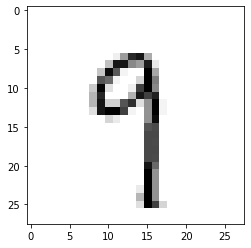

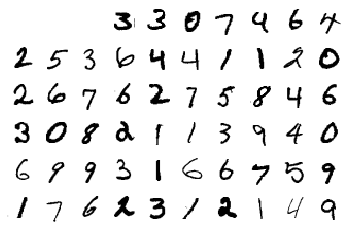

In [8]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[1].numpy().squeeze(), cmap='gray_r')

figure = plt.figure()
num_of_images = 60
for index in range(4, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [9]:

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1, 16):
    print("epoches:",epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

epoches: 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.04601689800620079 Batch_id=468 Accuracy=90.11: 100%|██████████| 469/469 [00:12<00:00, 37.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0882, Accuracy: 9744/10000 (97.44%)

epoches: 2


Loss=0.062181178480386734 Batch_id=468 Accuracy=97.78: 100%|██████████| 469/469 [00:12<00:00, 38.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0568, Accuracy: 9834/10000 (98.34%)

epoches: 3


Loss=0.08945218473672867 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:12<00:00, 37.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0458, Accuracy: 9852/10000 (98.52%)

epoches: 4


Loss=0.039327774196863174 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:12<00:00, 42.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0496, Accuracy: 9851/10000 (98.51%)

epoches: 5


Loss=0.023238107562065125 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:12<00:00, 38.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0358, Accuracy: 9887/10000 (98.87%)

epoches: 6


Loss=0.0657985582947731 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:12<00:00, 36.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0342, Accuracy: 9886/10000 (98.86%)

epoches: 7


Loss=0.01798434555530548 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:12<00:00, 36.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0347, Accuracy: 9882/10000 (98.82%)

epoches: 8


Loss=0.0658436119556427 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:13<00:00, 35.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0332, Accuracy: 9890/10000 (98.90%)

epoches: 9


Loss=0.07194408774375916 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:13<00:00, 35.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0307, Accuracy: 9901/10000 (99.01%)

epoches: 10


Loss=0.004551529884338379 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:13<00:00, 35.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0370, Accuracy: 9882/10000 (98.82%)

epoches: 11


Loss=0.004218047019094229 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:12<00:00, 36.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0495, Accuracy: 9836/10000 (98.36%)

epoches: 12


Loss=0.02003360725939274 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:13<00:00, 36.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0323, Accuracy: 9898/10000 (98.98%)

epoches: 13


Loss=0.012727171182632446 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:12<00:00, 34.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0345, Accuracy: 9888/10000 (98.88%)

epoches: 14


Loss=0.06687943637371063 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:12<00:00, 36.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0313, Accuracy: 9894/10000 (98.94%)

epoches: 15


Loss=0.013920024037361145 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:13<00:00, 35.07it/s]



Test set: Average loss: 0.0298, Accuracy: 9892/10000 (98.92%)

